### Random forest

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose

In [2]:
# Load dataset
base_dir = "../datasets/"
orders_df = pd.read_csv(base_dir + "orders.csv")

# Convert timestamp to date time
orders_df["created_at"] = pd.to_datetime(orders_df["created_at"])

# Create date related features
# Year and month are left out, see
orders_df["day_of_week"] = orders_df["created_at"].dt.dayofweek
orders_df["month"] = orders_df["created_at"].dt.month
orders_df["time_of_day"] = orders_df["created_at"].dt.hour + orders_df["created_at"].dt.minute / 60
orders_df["day_of_month"] = orders_df["created_at"].dt.day 

In [3]:
# Filter outliers

filter_elevation = (orders_df["to_user_elevation"] < 600) 
filter_earnings = (orders_df["total_earning"] < 40000) & (orders_df["total_earning"] > 0)
filter_distance = orders_df["to_user_distance"] < 8

orders_df = orders_df[filter_elevation & filter_earnings & filter_distance]

In [4]:
orders_df.columns

Index(['order_id', 'store_id', 'to_user_distance', 'to_user_elevation',
       'total_earning', 'created_at', 'taken', 'day_of_week', 'month',
       'time_of_day', 'day_of_month'],
      dtype='object')

In [5]:
features = orders_df[["to_user_distance", "to_user_elevation", "total_earning", "day_of_week", "time_of_day", "day_of_month"]]
labels = orders_df["taken"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size = 0.25, stratify=labels, random_state=314)

In [6]:
# Verify selected features
X_train.columns

Index(['to_user_distance', 'to_user_elevation', 'total_earning', 'day_of_week',
       'time_of_day', 'day_of_month'],
      dtype='object')

In [7]:
# Verify strtification
y_test.describe()

count    36744.000000
mean         0.921212
std          0.269412
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: taken, dtype: float64

In [9]:
# First model using weight balancing
model = ensemble.RandomForestClassifier(n_estimators=100, min_samples_split=1000, max_depth=20, class_weight="balanced", max_leaf_nodes=100)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_leaf_nodes=100, min_samples_split=1000)

In [10]:
# Get scores
print( "ROC-auc train", metrics.roc_auc_score(y_train, model.predict(X_train)))
print( "ROC-auc test", metrics.roc_auc_score(y_test, model.predict(X_test)))

ROC-auc train 0.6830791785622553
ROC-auc train 0.6600150439539699


<AxesSubplot:xlabel='x', ylabel='y'>

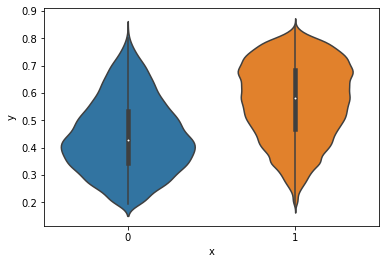

In [11]:
# Plot violin plot to have an idea of the class separations
probs_train = model.predict_proba(X_train)

plot_df = pd.DataFrame({"x": y_train, "y": probs_train[:, 1]})
sns.violinplot(data=plot_df, y="y", x="x")

The random forest separates better both classes...

Is it perhaps better to scale the featues...it should not make much difference

In [12]:
# K fold cross validation performace of model with no scaling
model_1 = ensemble.RandomForestClassifier(n_estimators=100, min_samples_split=1000, max_depth=20, class_weight="balanced", max_leaf_nodes=100)
result = model_selection.cross_validate(model_1, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

# K fold cross validation performace of model with scaling
model_2 = pipeline.Pipeline( [("scaler", preprocessing.StandardScaler()), ("predictor", model_1)] )
result = model_selection.cross_validate(model_2, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))


# K fold cross validation performace of model with one hot encoding of day of week
compose_scaler = compose.ColumnTransformer( [("scaler", preprocessing.StandardScaler(), ['to_user_distance', 'to_user_elevation', 'total_earning', 'time_of_day'])],
                                                        remainder="passthrough")

compose_encoder = compose.ColumnTransformer( [("encoder", preprocessing.OneHotEncoder(), [4, 5])],
                                             remainder="passthrough")

model_3 = pipeline.Pipeline( [  ("scaler", compose_scaler), 
                                ("encoder", compose_encoder), 
                                ("predictor", model_1)] )

result = model_selection.cross_validate(model_3, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))


Plain model score:  [0.72198092 0.71266234 0.71743894 0.70876174 0.72087879]
mean test score:  0.7163445435834437
mean train score:  0.74880333288658
Plain model score:  [0.72142678 0.7133679  0.71844487 0.70898827 0.72231814]
mean test score:  0.7169091933768357
mean train score:  0.7493335286674647
Plain model score:  [0.71515465 0.71068011 0.71192176 0.6988689  0.71464697]
mean test score:  0.7102544784972009
mean train score:  0.7370420584652779


Scaling does not increments performance, one hot encoding does not increase performance in this case

#### Add popular store info...

In [13]:
# In this cell we want to compute if a store is popular, in the sense that many orders are taken for that store
# We compute the probability of taken for the store ids
# This probability is only reliable if we have enough data for that particular store
# We define a store to be popular if:
#     (number_data_points(store_id) > th1) and (prob_taken(store_id) > th2
# We define a store to be un_popular if:
#     (number_data_points(store_id) > th1) and (prob_taken(store_id) < th3
# If a store is not popular or unpopular the it is undefined

aux = orders_df.copy()

# Add columns "is_taken" and "not_taken"
aux["is_taken"] = (aux["taken"] == 1) 
aux["not_taken"] = (aux["taken"] == 0)

# Group by store_id and sum the number of taken, is_taken and not_taken
aux = aux.groupby("store_id").agg("sum")[["taken", "is_taken", "not_taken"]]

# Total orders is just the sum of taken and not taken
aux["total_orders"] = (aux["is_taken"] + aux["not_taken"])

# The store rating is its propability of taken
aux["rating"] = aux["is_taken"] / aux["total_orders"] 
aux = aux.sort_values("rating", ascending=False)

# Create the popularity column
aux["popularity"] = 0

th1 = 50
th2 = 0.66
th3 = 0.33
filter_popular = (aux["total_orders"] > th1) & (aux["rating"] > th2)
filter_unpopular = (aux["total_orders"] > th1) & (aux["rating"] < th3)

aux.loc[filter_popular, "popularity"] = 1
aux.loc[filter_unpopular, "popularity"] = -1

# Get the popular stores
popular_store_ids = aux.loc[ aux["popularity"] == 1].index
popular_stores_ids = list(popular_store_ids)


In [14]:
X_train_popular = X_train.copy()
X_train_popular["store_id"] = orders_df.loc[X_train_popular.index, "store_id"]
X_train_popular["popular_store"] = X_train_popular.apply( lambda row: 1 if (row.store_id in popular_store_ids) else 0, axis=1 )
X_train_popular.drop(columns="store_id", inplace=True)

In [15]:
# K fold cross validation performace of model with one hot encoding of day of week
compose_scaler = compose.ColumnTransformer( [("scaler", preprocessing.StandardScaler(), ['to_user_distance', 'to_user_elevation', 'total_earning', 'time_of_day'])],
                                                        remainder="passthrough")

compose_encoder = compose.ColumnTransformer( [("encoder", preprocessing.OneHotEncoder(), [4, 5])],
                                             remainder="passthrough")

model_3 = pipeline.Pipeline( [  ("scaler", compose_scaler), 
                                ("encoder", compose_encoder), 
                                ("predictor", model_1)] )

result = model_selection.cross_validate(model_3, X_train_popular, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

Plain model score:  [0.71712593 0.71396957 0.71661866 0.70173966 0.71664756]
mean test score:  0.7132202746779301
mean train score:  0.7396591940642575


No change adding popular stores ids...

### Fine tuning - parameter optimizations

In [49]:
model = ensemble.RandomForestClassifier(n_estimators=100, min_samples_split=1000, max_depth=20, class_weight="balanced", max_leaf_nodes=100)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 100, 1000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# ;ax leaf nodes
max_leaf_nodes= [10, 50, 100, 200, None]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

random_search = model_selection.RandomizedSearchCV( model, 
                                                    param_distributions=random_grid, 
                                                    n_iter=25,
                                                    scoring="roc_auc",
                                                    cv=5,
                                                    refit=False,
                                                    random_state=314,
                                                    return_train_score=True
                                )

In [51]:
result = random_search.fit(X_train, y_train)

In [52]:
random_search.cv_results_

{'mean_fit_time': array([ 8.34786687,  8.27620044,  9.74055014, 10.13704538,  4.53684158,
         5.02132301,  4.83336453,  6.60194283,  3.74895058,  3.91556158,
         5.0776834 ,  3.30332265,  9.33463693,  8.98345408,  6.19160571,
         5.45703812,  2.5358386 , 13.87705884, 10.26902409, 18.72459702,
         3.24834433,  7.45132837, 10.94447546,  8.85800495, 10.05396943]),
 'std_fit_time': array([0.11426394, 0.22871625, 0.05706231, 0.0399617 , 0.06011939,
        0.12438112, 0.08425802, 0.12949209, 0.06886514, 0.01989041,
        0.05318024, 0.02880925, 0.06365248, 0.12736501, 0.10448899,
        0.06319445, 0.0441031 , 0.27761832, 0.19968596, 0.80746102,
        0.03376782, 0.16024089, 0.10213115, 0.1483919 , 0.45660659]),
 'mean_score_time': array([0.24139652, 0.185217  , 0.22264643, 0.24293962, 0.1114048 ,
        0.12412434, 0.14288301, 0.14879827, 0.09318829, 0.09708061,
        0.11670451, 0.07890515, 0.20999436, 0.20230365, 0.14749856,
        0.13388214, 0.06785059, 0.3

In [54]:
result.best_score_

0.73600807931959

In [55]:
result.best_params_

{'n_estimators': 87,
 'min_samples_split': 100,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': 50}

In [67]:
# Try out best parameters
model_1 = ensemble.RandomForestClassifier(  n_estimators=87, 
                                            min_samples_split=100, 
                                            min_samples_leaf=2,
                                            max_depth=50, 
                                            class_weight="balanced", 
                                            max_leaf_nodes=None, 
                                            max_features="sqrt")
result = model_selection.cross_validate(model_1, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

Plain model score:  [0.74385797 0.73675765 0.73398269 0.72987309 0.73460127]
mean test score:  0.7358145353199232
mean train score:  0.9090384271482851


This model overfitts too much...lets try out the second best parameters: 
   - 'n_estimators': 131,
   - 'min_samples_split': 100,
   - 'min_samples_leaf': 2,
   - 'max_leaf_nodes': 200,
   - 'max_features': 'sqrt',
   - 'max_depth': 50}],

In [78]:
model_1 = ensemble.RandomForestClassifier(  n_estimators=131, 
                                            min_samples_split=100, 
                                            min_samples_leaf=2,
                                            max_depth=50, 
                                            class_weight="balanced", 
                                            max_leaf_nodes=200, 
                                            max_features="sqrt")
result = model_selection.cross_validate(model_1, X_train, y_train, cv=5, scoring="roc_auc", return_train_score=True)
print("Plain model score: ", result["test_score"])
print("mean test score: ", np.mean(result["test_score"]))
print("mean train score: ", np.mean(result["train_score"]))

Plain model score:  [0.73089652 0.72431967 0.72785914 0.71869905 0.73076807]
mean test score:  0.7265084893207089
mean train score:  0.7892989973731412


This model overfitts less, lets keep this model.

Compute the performace over the test set:

In [80]:
# Train over entire train test and evaluate over test set
model_1 = ensemble.RandomForestClassifier(  n_estimators=131, 
                                            min_samples_split=100, 
                                            min_samples_leaf=2,
                                            max_depth=50, 
                                            class_weight="balanced", 
                                            max_leaf_nodes=200, 
                                            max_features="sqrt")

model_1.fit(X_train, y_train)
predictions = model_1.predict(X_test)
print("Test score: ", metrics.roc_auc_score(y_test, predictions))

Test score:  0.6660055164226004
